In [12]:
# importing some libraries we need in this part
import scipy.io
import numpy as np
import os
from collections import defaultdict, Counter
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from cmath import pi
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.signal import stft
from scipy import signal
import numpy as np
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.signal import savgol_filter
import pywt  # For wavelet transform

In [13]:
# Load the dataset
import pickle
with open('Data/trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)
CSI = trainset['CSI'][1]  # the CSI series
groundtruth = trainset['groundtruth'][1]  # loading the ground-truth
experiment_name = trainset['ex_name'][1][:-4]
CSI_amplitude = np.abs(trainset['CSI'][1]) 


# Select the specific subcarrier and link
selected_subcarrier = 15
selected_Rx = 0
selected_Tx = 1
csi_amplitude = CSI_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]

# Define sampling rate
sampling_rate = 100  # Hz


In [14]:
from scipy import signal
from scipy.signal import savgol_filter
from statsmodels.robust import mad  # For Hampel Filter
import pywt

def preprocess_with_filters(CSI, filter_type, phase_integration=False):
    CSI_amplitude = np.abs(CSI)
    CSI_phase = np.angle(CSI)
    b, a = signal.butter(1, [0.002, 0.005], 'bandpass')
    # Filter Parameters
    if filter_type == "Butterworth":
        b, a = signal.butter(1, [0.002, 0.005], 'bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)

    elif filter_type == "Savitzky-Golay":
        filtered_amplitude = savgol_filter(CSI_amplitude, window_length=101, polyorder=3, axis=0)

    elif filter_type == "Wavelet":
        filtered_amplitude = np.empty_like(CSI_amplitude)
        for i in range(CSI_amplitude.shape[1]):
            coeffs = pywt.wavedec(CSI_amplitude[:, i], 'db4', level=2)
            coeffs[-1] = pywt.threshold(coeffs[-1], value=0.2, mode='soft')
            filtered_amplitude[:, i] = pywt.waverec(coeffs, 'db4')[:CSI_amplitude.shape[0]]

    elif filter_type == "Hampel":
        window_size = 11
        threshold = 3.0
        filtered_amplitude = np.apply_along_axis(lambda x: signal.medfilt(x, kernel_size=5), axis=0, arr=CSI_amplitude)

    elif filter_type == "Bandpass":
        b, a = signal.butter(4, [0.002, 0.005], btype='band')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)

    else:
        raise ValueError(f"Unsupported filter: {filter_type}")

    if phase_integration:
        filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)
        return filtered_amplitude + filtered_phase  # Combine amplitude and phase

    return filtered_amplitude

# Apply filters
filters = ["Butterworth", "Savitzky-Golay", "Wavelet", "Hampel", "Bandpass"]
processed_data = {}

for f in filters:
    print(f"Processing with {f} filter...")
    processed_data[f] = preprocess_with_filters(CSI, f, phase_integration=True)


Processing with Butterworth filter...
Processing with Savitzky-Golay filter...
Processing with Wavelet filter...
Processing with Hampel filter...
Processing with Bandpass filter...


In [15]:
from scipy.signal import stft

features = {}

for f in filters:
    processed_amplitude = processed_data[f]
    selected_subcarrier = 15
    selected_Rx, selected_Tx = 0, 1

    # Select component
    selected_component = processed_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]

    # FFT and STFT
    frequencies, times, stft_feature = stft(selected_component, fs=100)
    stft_avg = np.abs(stft_feature).mean(axis=1)

    # Save features
    features[f] = {
        "fft": np.fft.fft(selected_component),
        "stft": stft_avg
    }

    print(f"Features extracted for {f} filter.")


Features extracted for Butterworth filter.
Features extracted for Savitzky-Golay filter.
Features extracted for Wavelet filter.
Features extracted for Hampel filter.
Features extracted for Bandpass filter.


In [16]:
# Peak Detection and Breathing Rate Estimation
results = {}

for f in filters:
    fft_feature = features[f]["fft"]

    # Peak detection
    max_value = np.max(np.abs(fft_feature))
    arg_max = np.argmax(np.abs(fft_feature))

    # Calculate estimated breath rate
    sampling_frequency = 100  # Hz
    frequency = arg_max * (sampling_frequency / len(fft_feature))
    estimated_breath_rate = frequency * 60  # BPM

    # Save results
    results[f] = estimated_breath_rate
    print(f"{f} Filter - Estimated Breathing Rate: {estimated_breath_rate:.2f} BPM")


Butterworth Filter - Estimated Breathing Rate: 15.00 BPM
Savitzky-Golay Filter - Estimated Breathing Rate: 0.00 BPM
Wavelet Filter - Estimated Breathing Rate: 0.00 BPM
Hampel Filter - Estimated Breathing Rate: 0.00 BPM
Bandpass Filter - Estimated Breathing Rate: 7.00 BPM


In [17]:
def result_visualization(groundtruth, final_result):
    """
    Visualize the comparison between ground truth and estimated breath rate series.
    """
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(groundtruth, label='Ground Truth', color='blue', linewidth=2)
    plt.plot(final_result, label='Estimated Breath Rate', color='red', linestyle='--', linewidth=2)

    # Adding annotations for the last predicted and ground truth values
    plt.annotate(f'Predicted: {final_result[-1]:.2f} BPM',
                 xy=(len(final_result)-1, final_result[-1]),
                 xytext=(len(final_result)-1, final_result[-1] + 2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12)
    
    plt.annotate(f'Ground Truth: {groundtruth[-1]:.2f} BPM',
                 xy=(len(groundtruth)-1, groundtruth[-1]),
                 xytext=(len(groundtruth)-1, groundtruth[-1] + 2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12)
    
    plt.title('Estimated Breath Rate vs Ground Truth', fontsize=16)
    plt.xlabel('Samples', fontsize=14)
    plt.ylabel('Breath Rate (BPM)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Save the figure
    output_dir = "Visualization/"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, 'breath_rate_comparison_with_annotations.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Visualization saved at: {output_path}")


In [18]:
def MSE(final_result, groundtruth):
    """
    Calculate Mean Squared Error (MSE) between the estimated and ground truth series.
    """
    re = np.array(final_result)  # Convert list to numpy array
    gr = np.array(groundtruth)  # Convert ground truth to numpy array
    return np.mean((re - gr) ** 2)  # Calculate and return the mean squared error


Butterworth Filter - MSE: 0.50


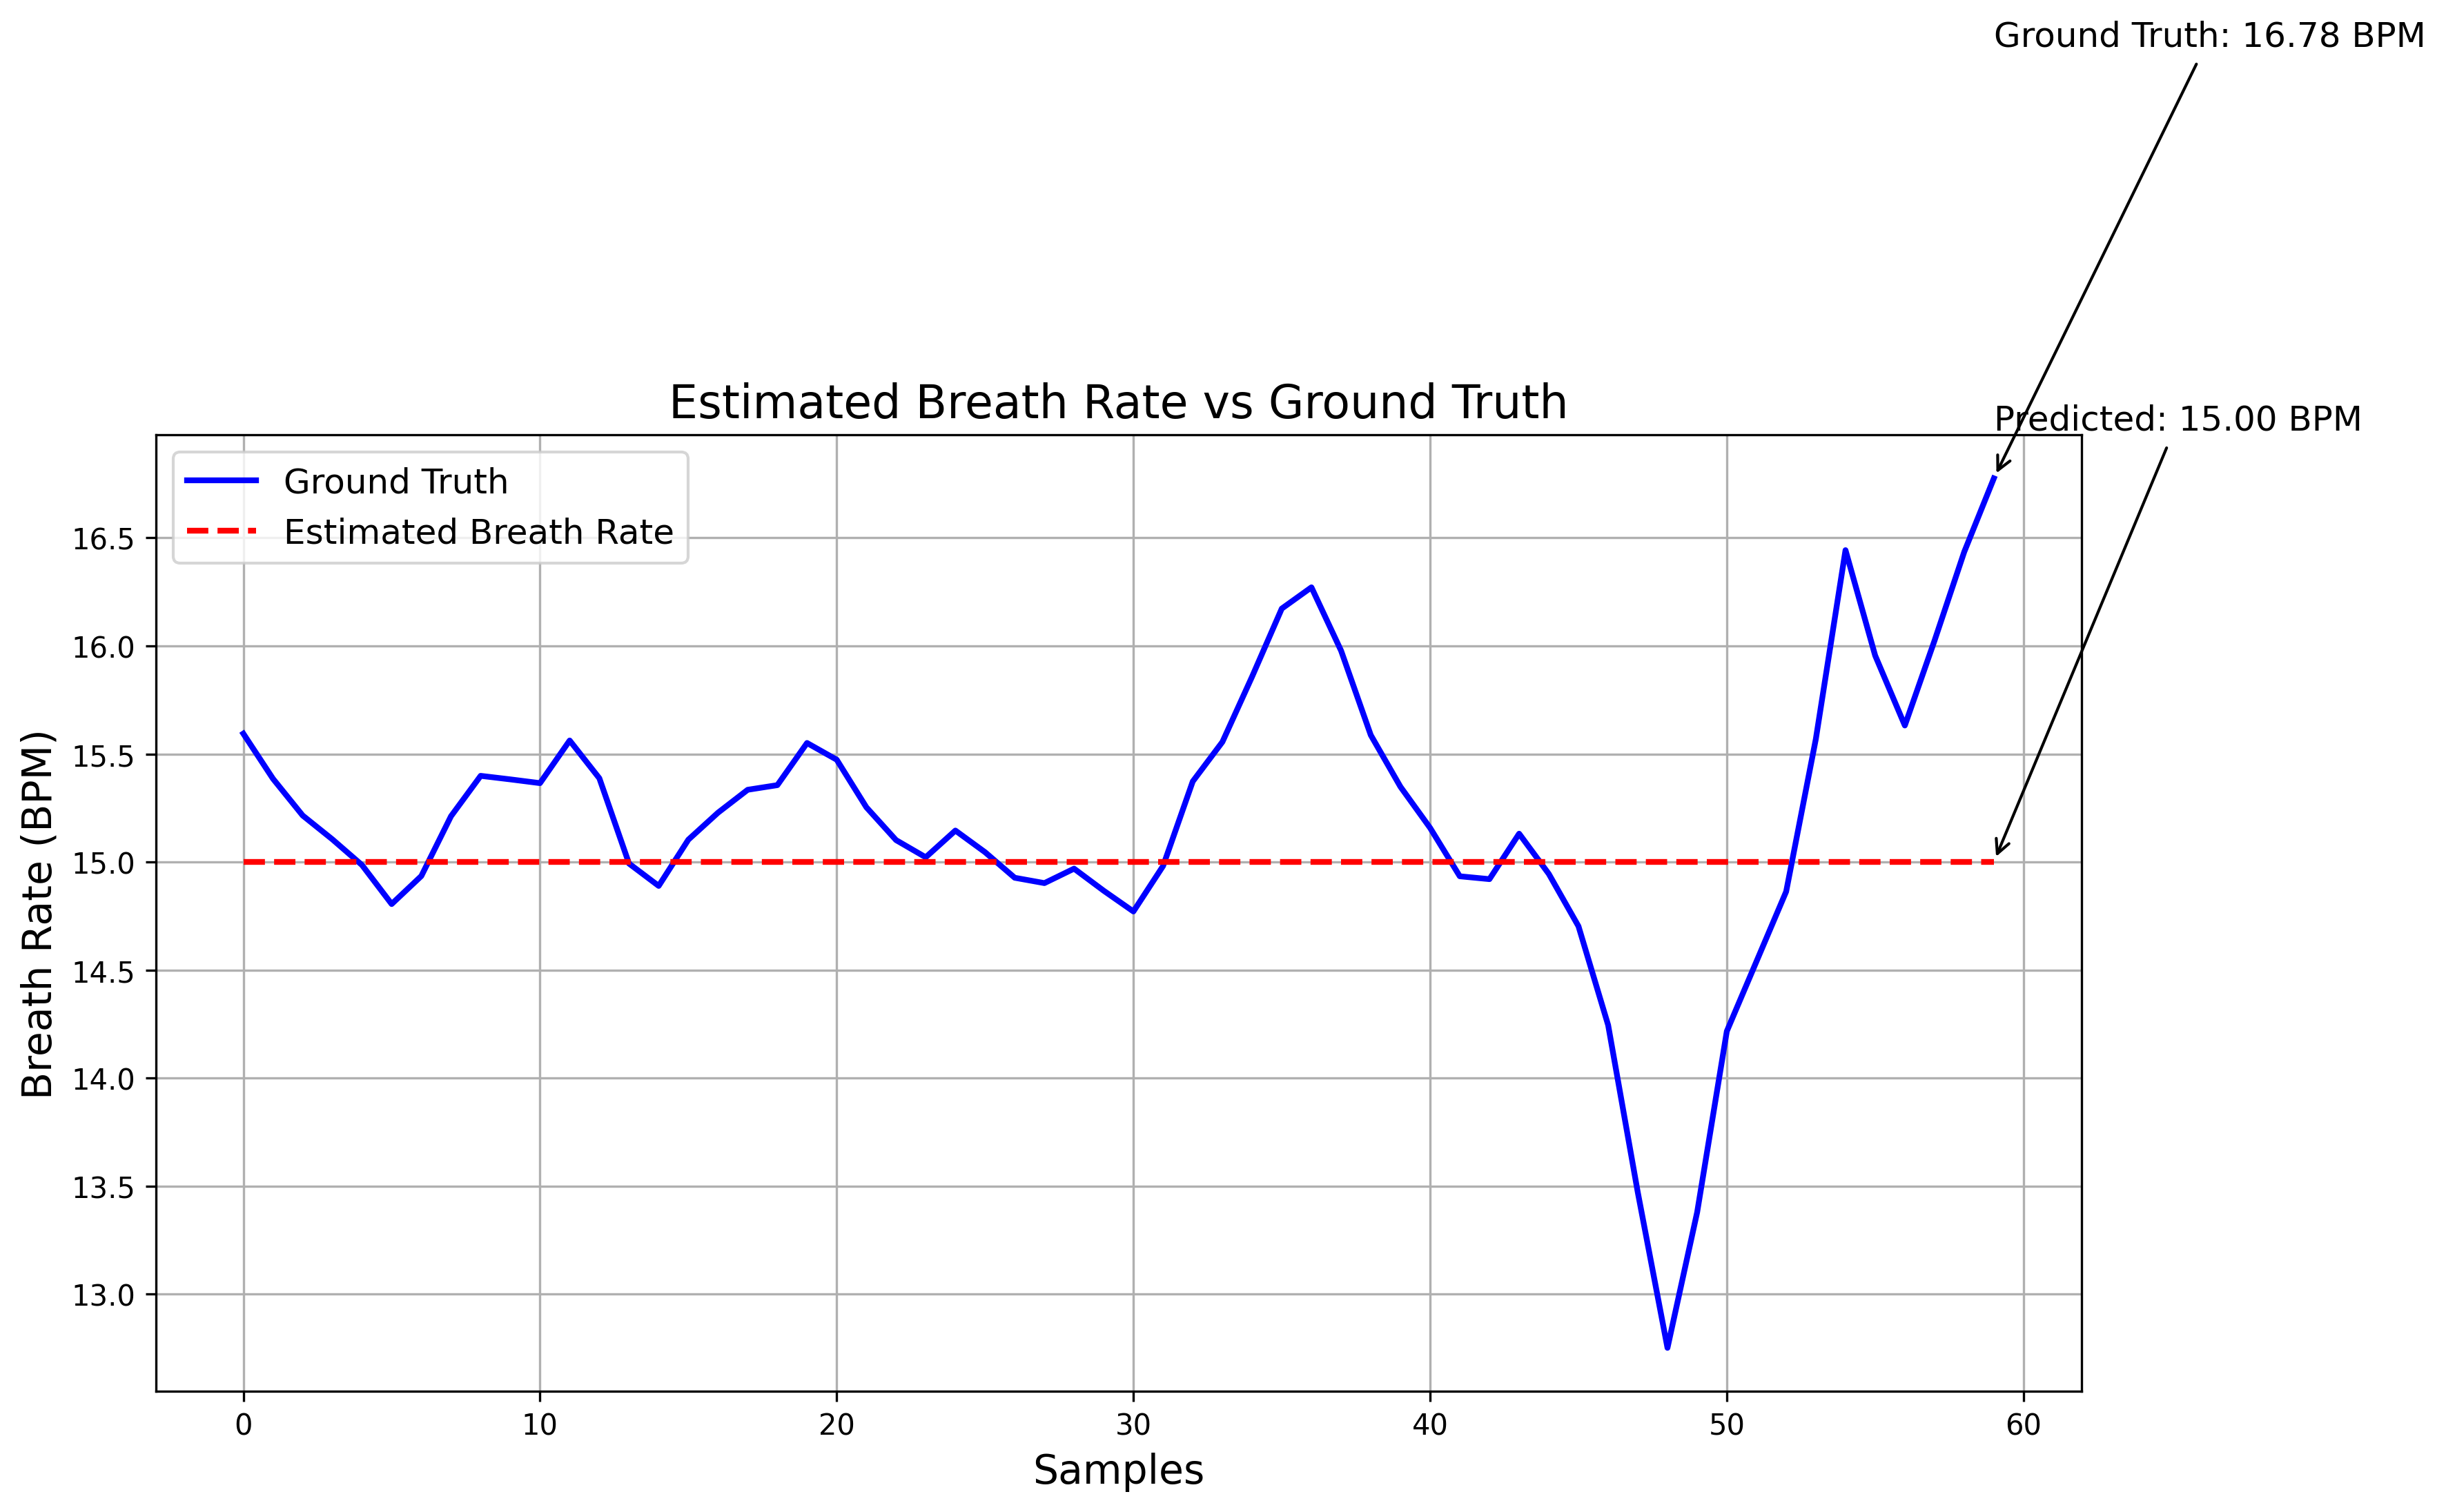

Visualization saved at: Visualization/breath_rate_comparison_with_annotations.png
Savitzky-Golay Filter - MSE: 231.24


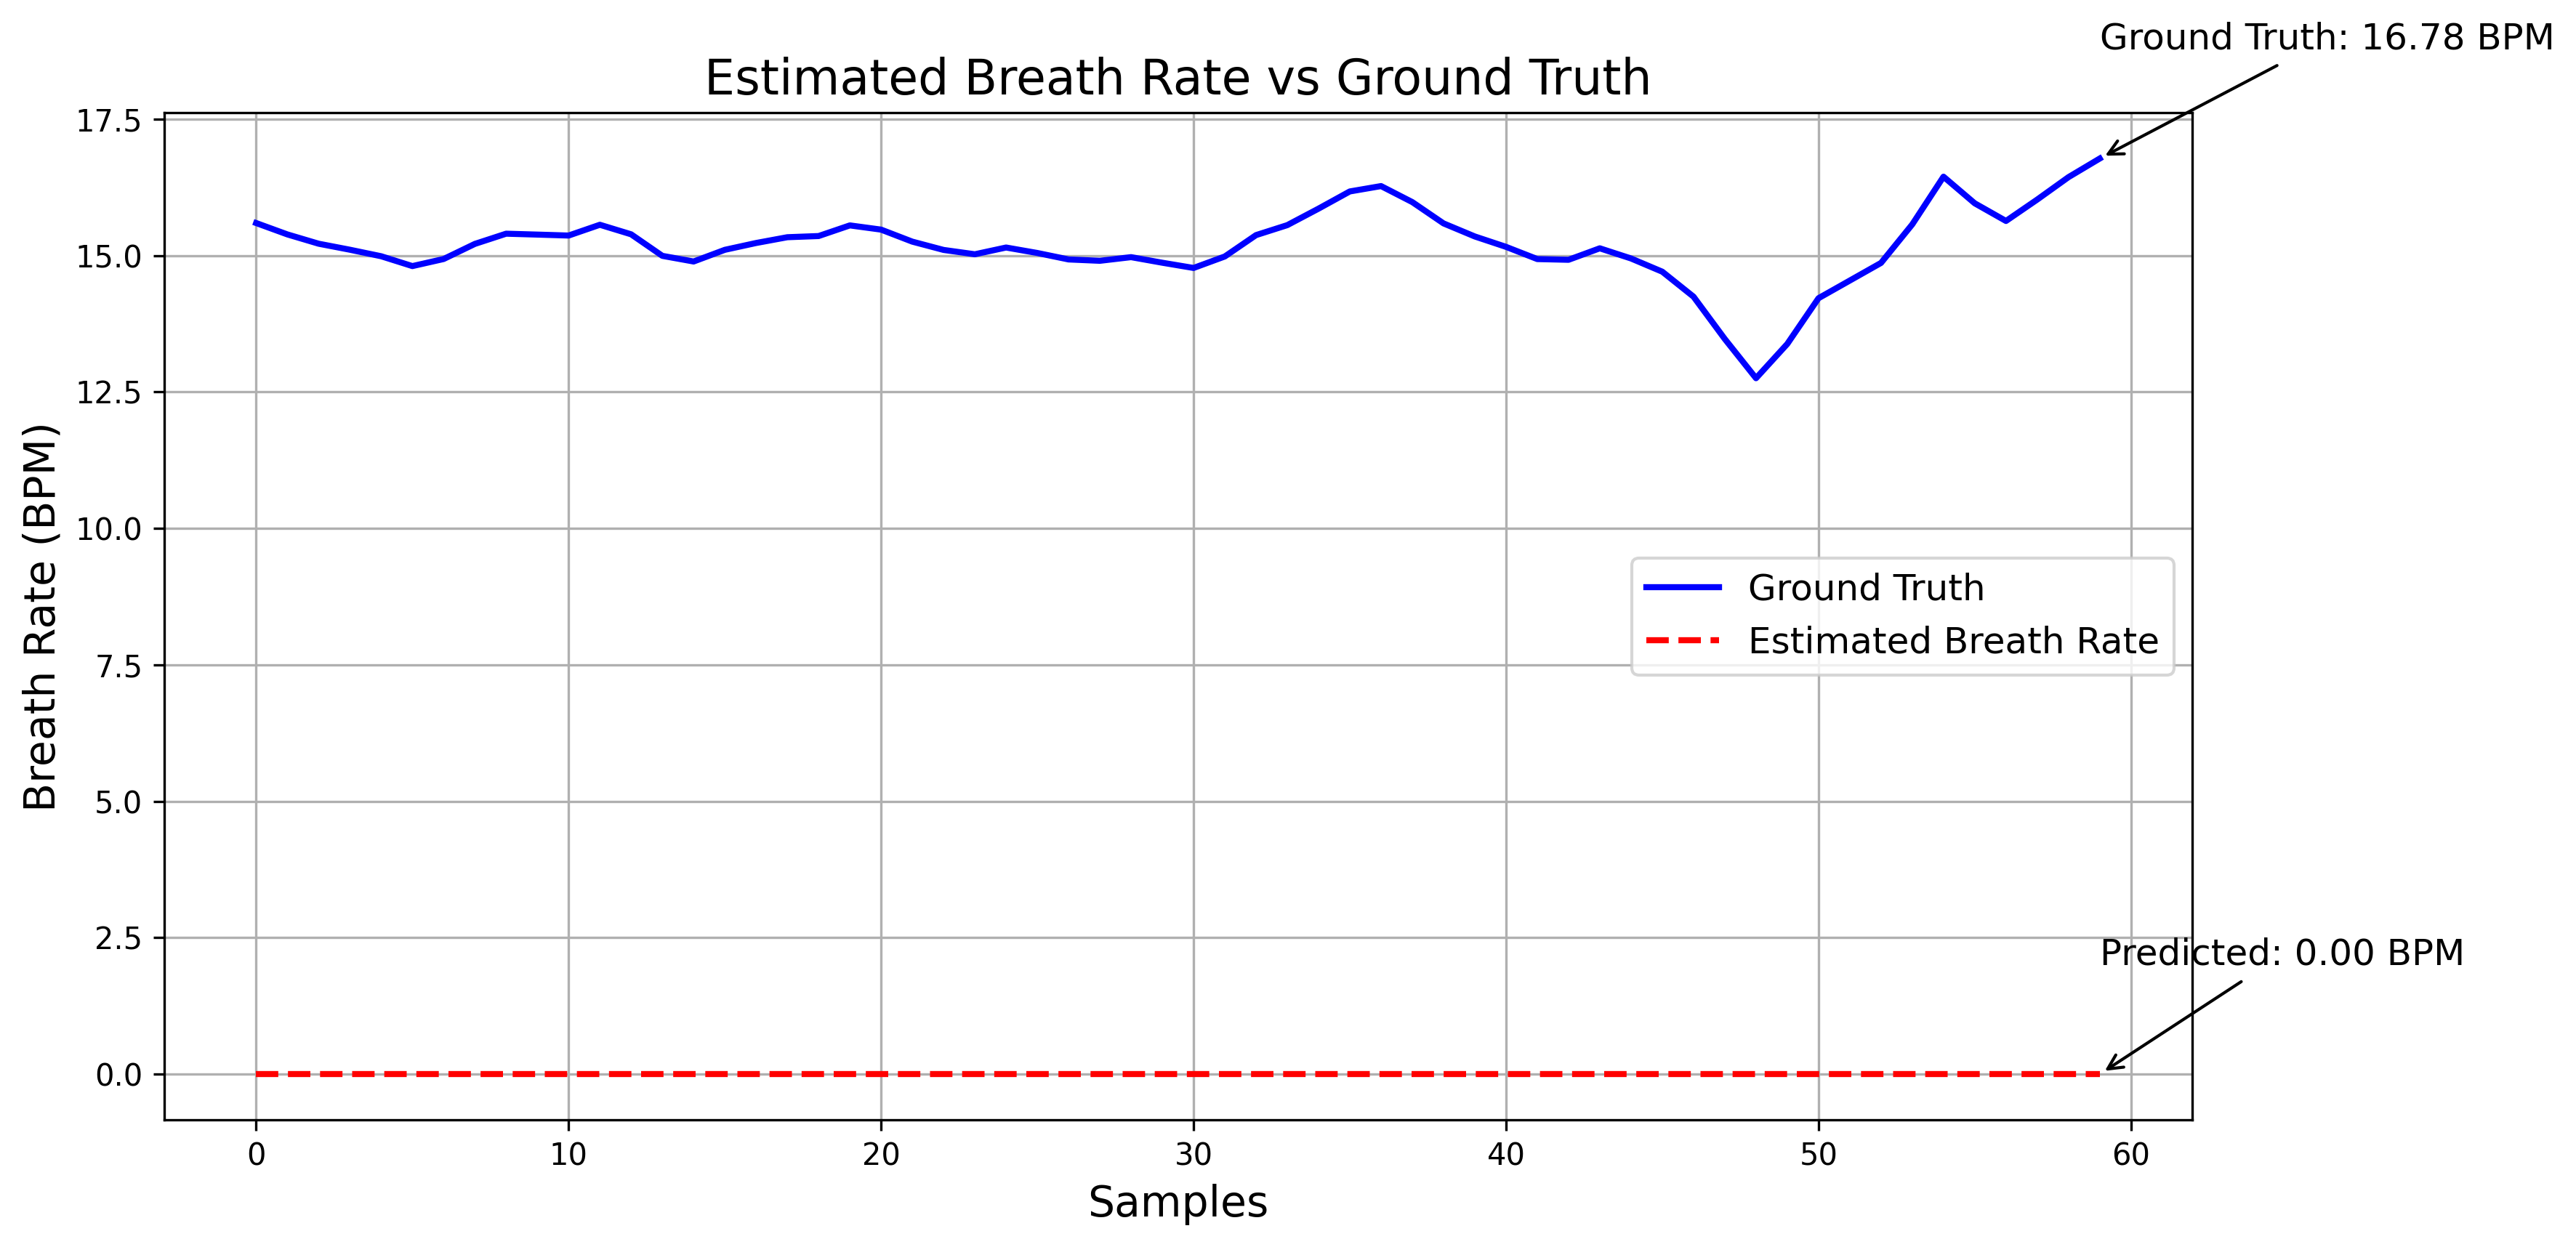

Visualization saved at: Visualization/breath_rate_comparison_with_annotations.png
Wavelet Filter - MSE: 231.24


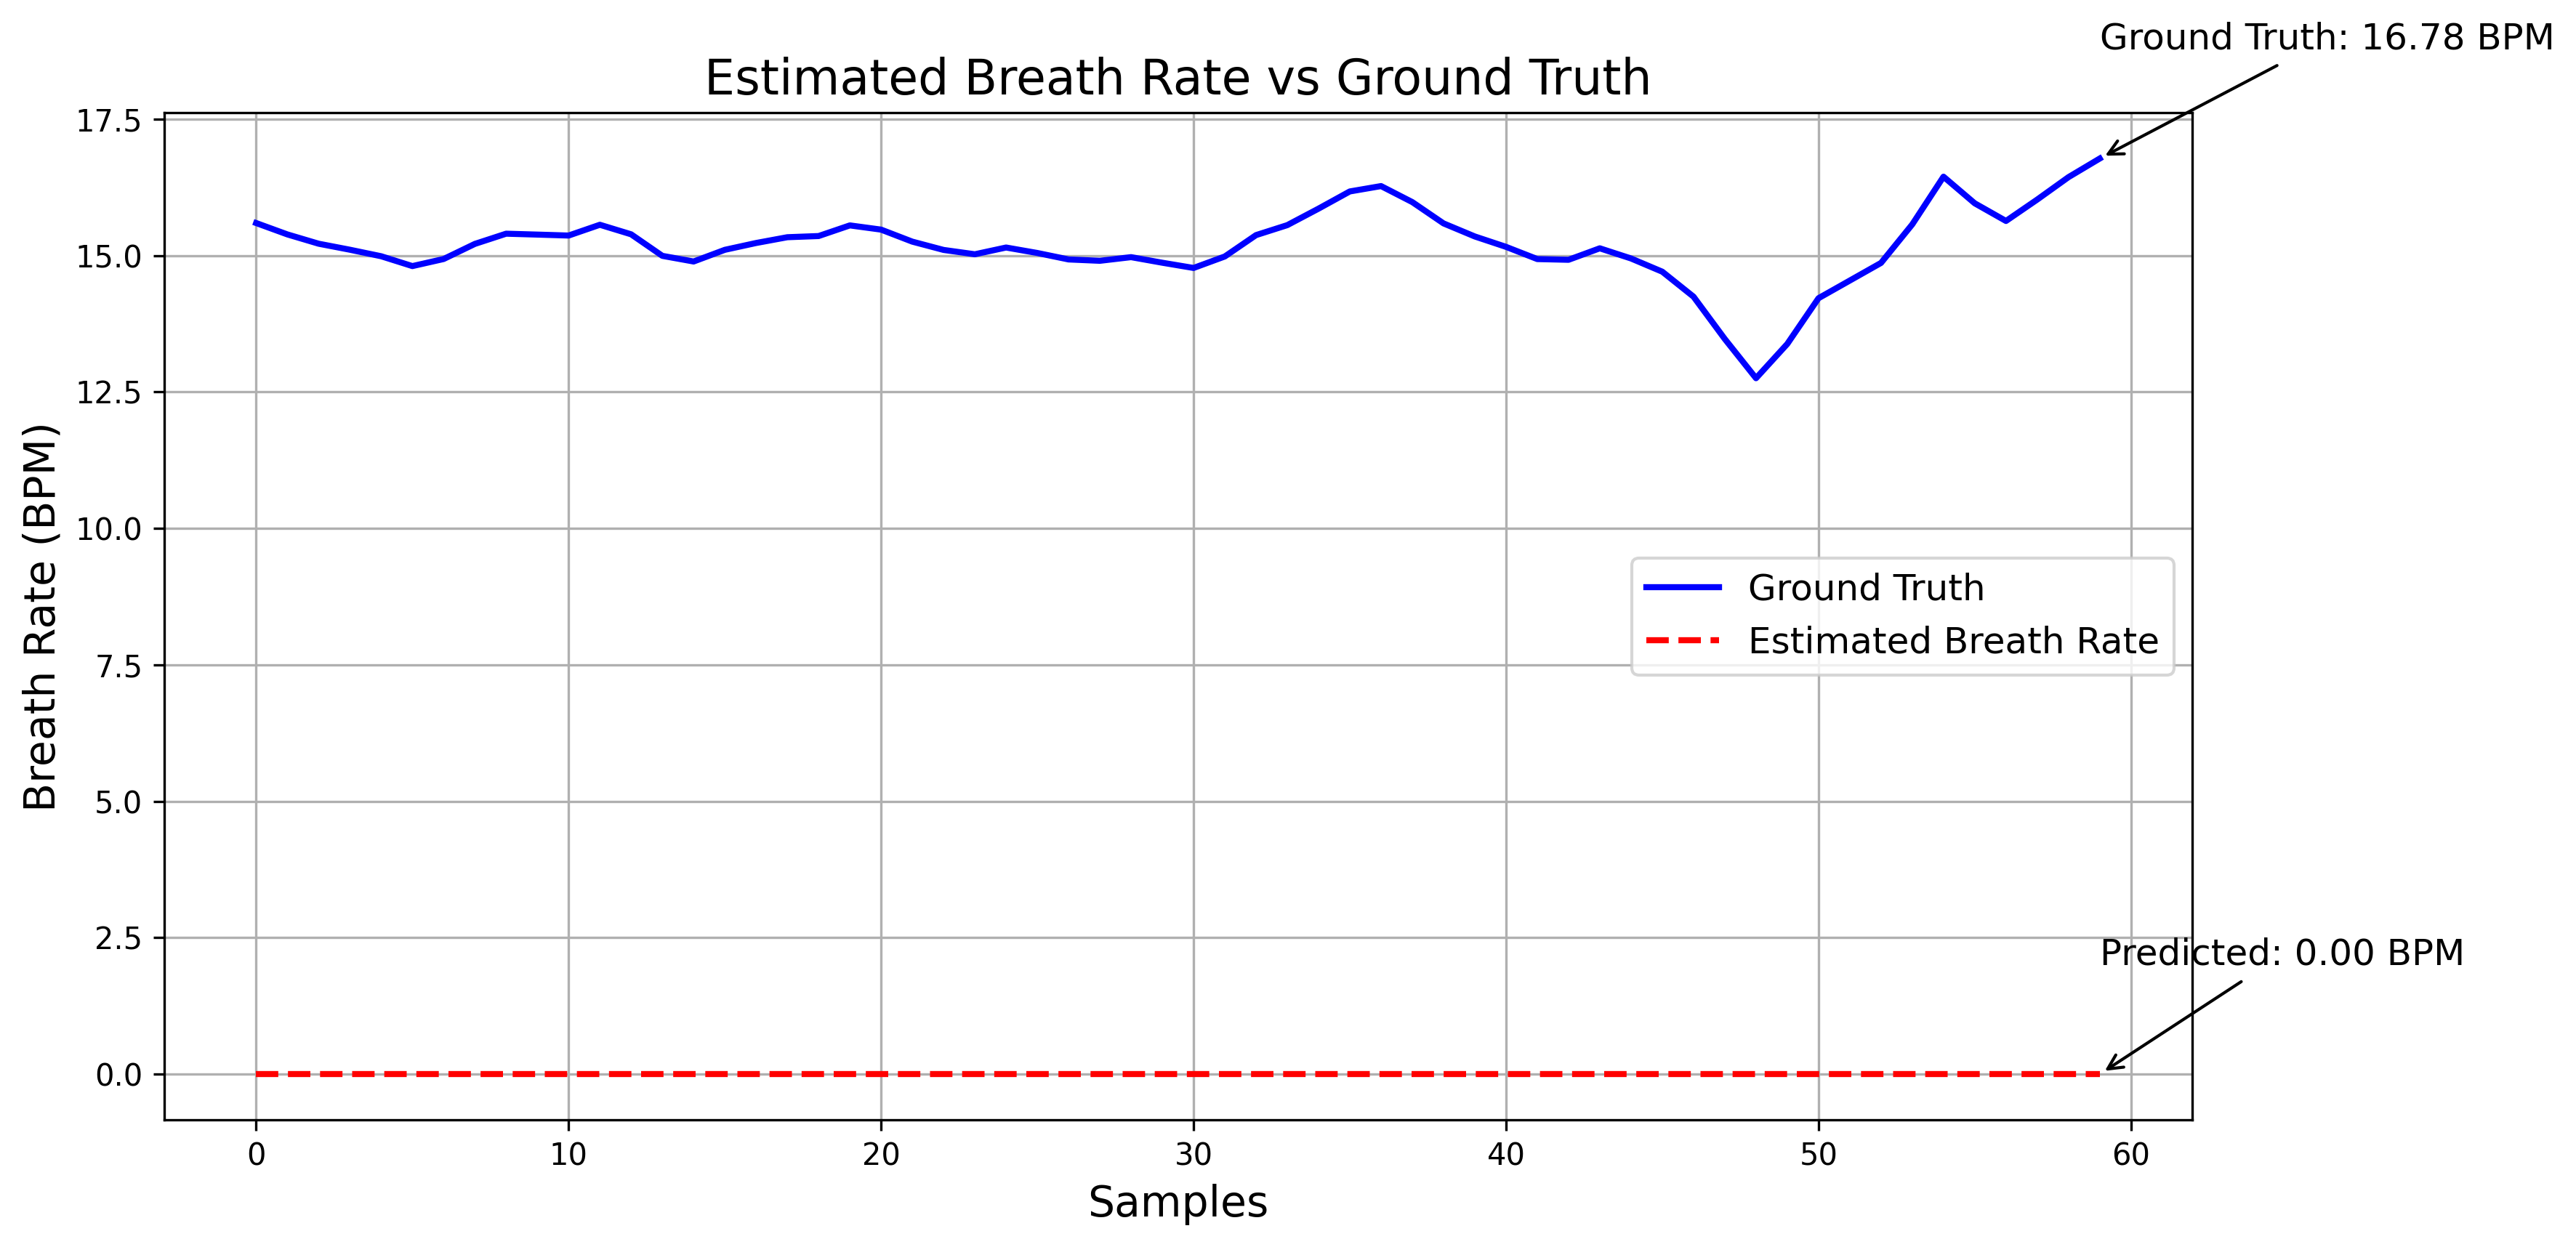

Visualization saved at: Visualization/breath_rate_comparison_with_annotations.png
Hampel Filter - MSE: 231.24


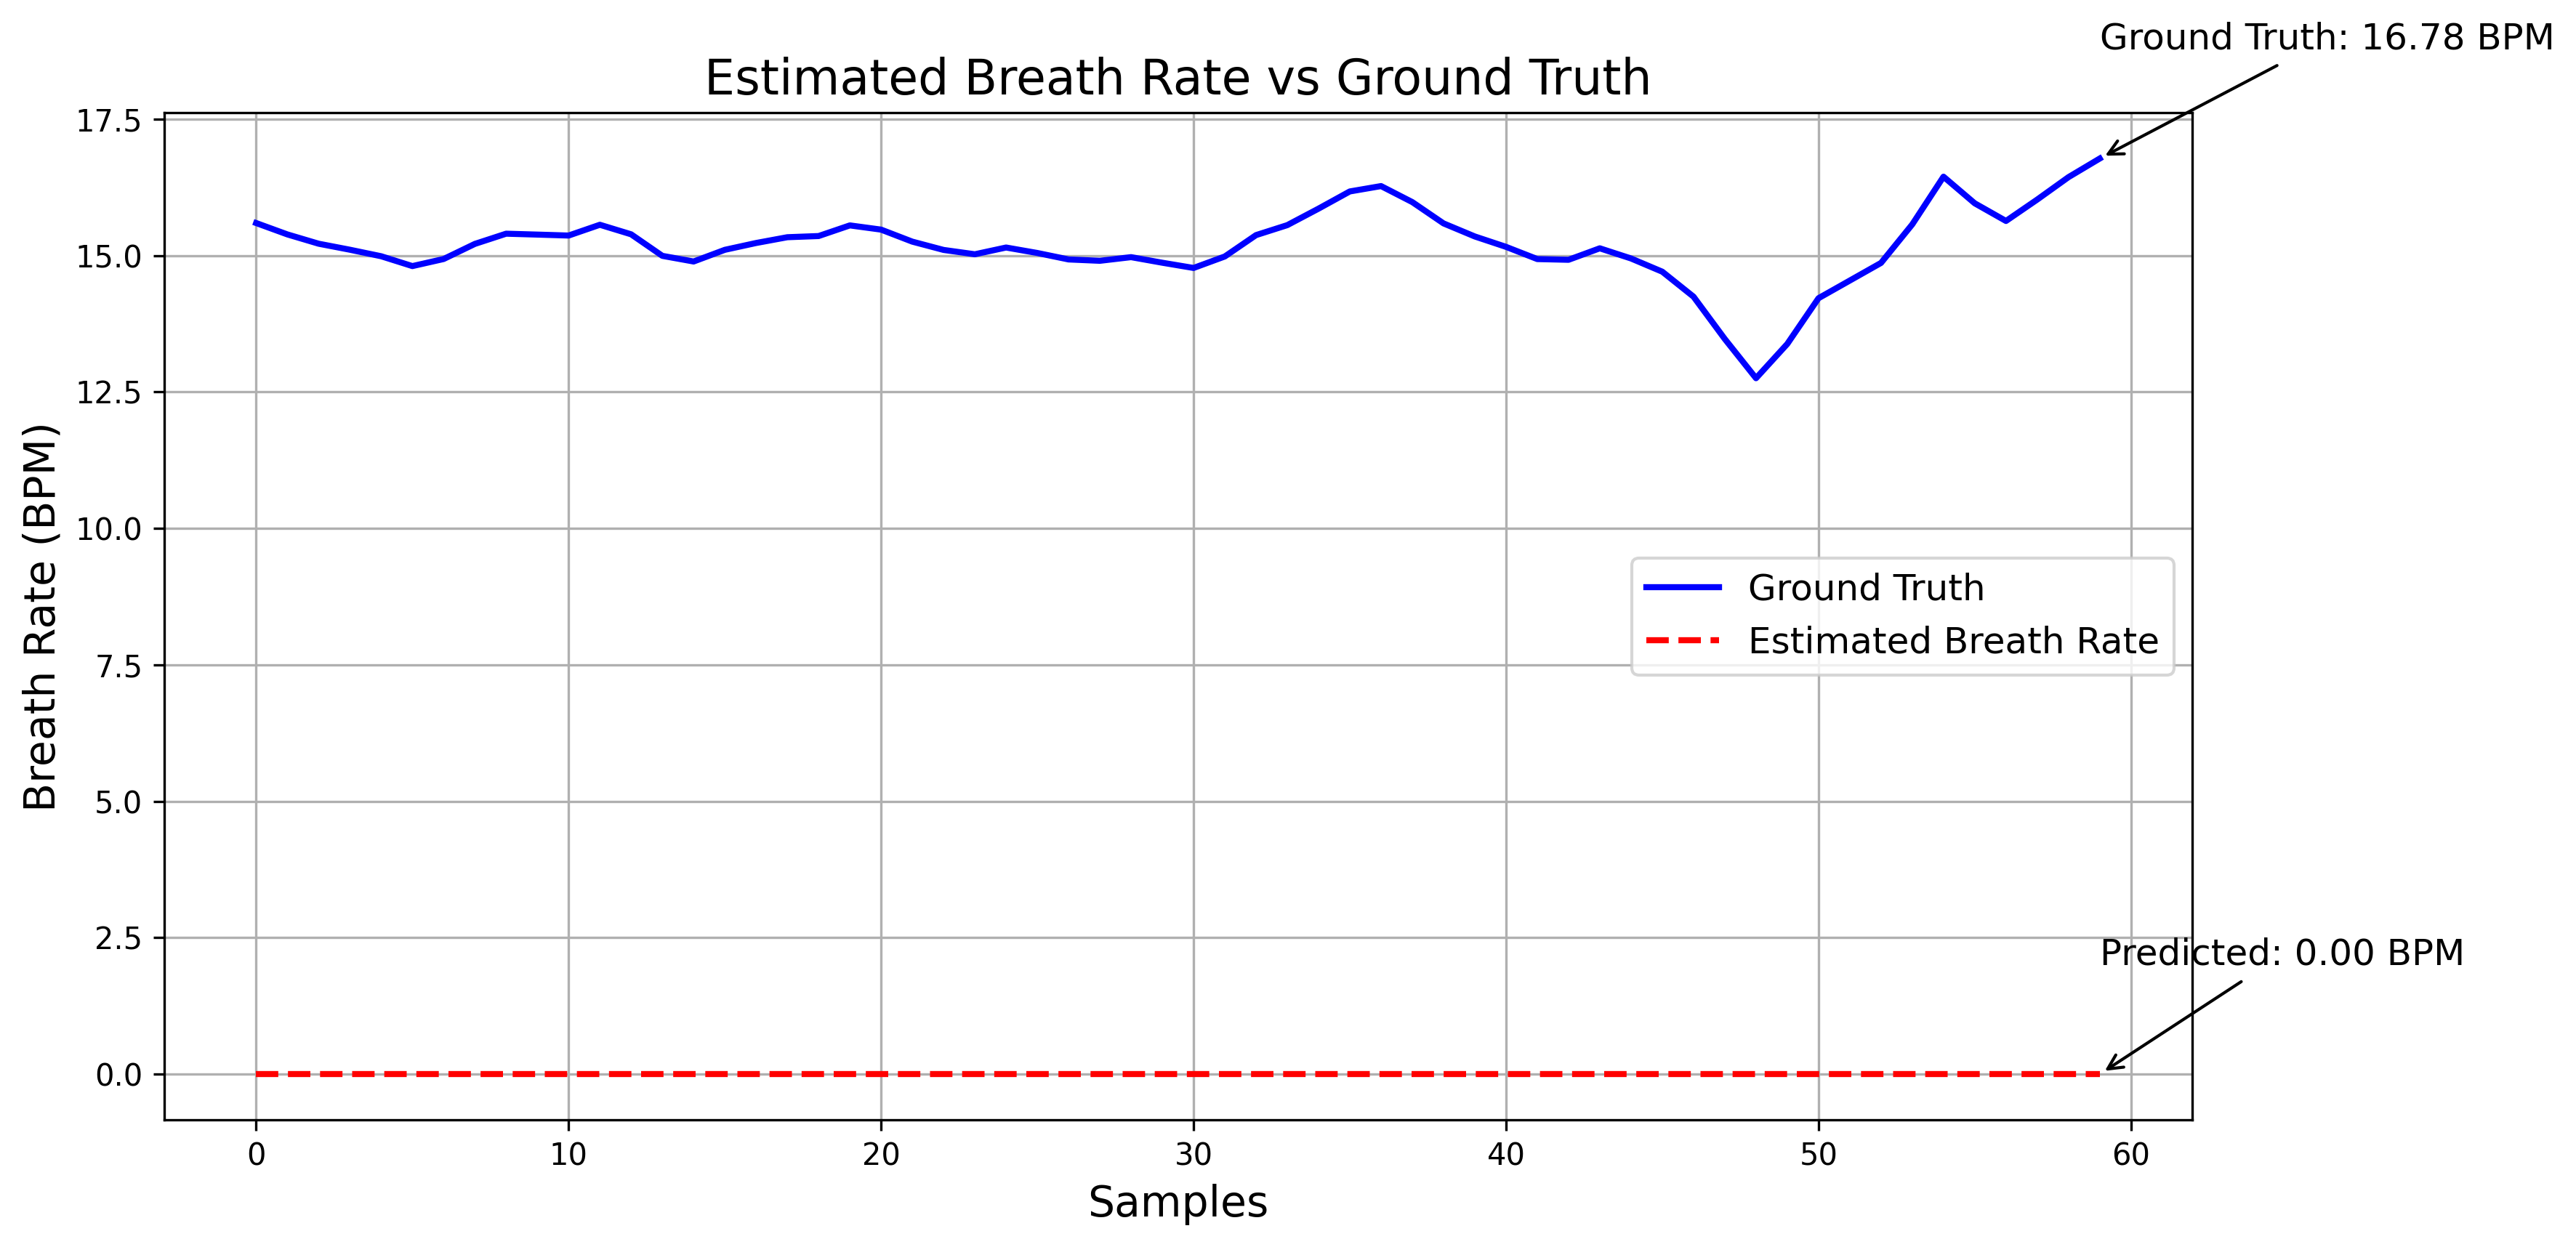

Visualization saved at: Visualization/breath_rate_comparison_with_annotations.png
Bandpass Filter - MSE: 67.56


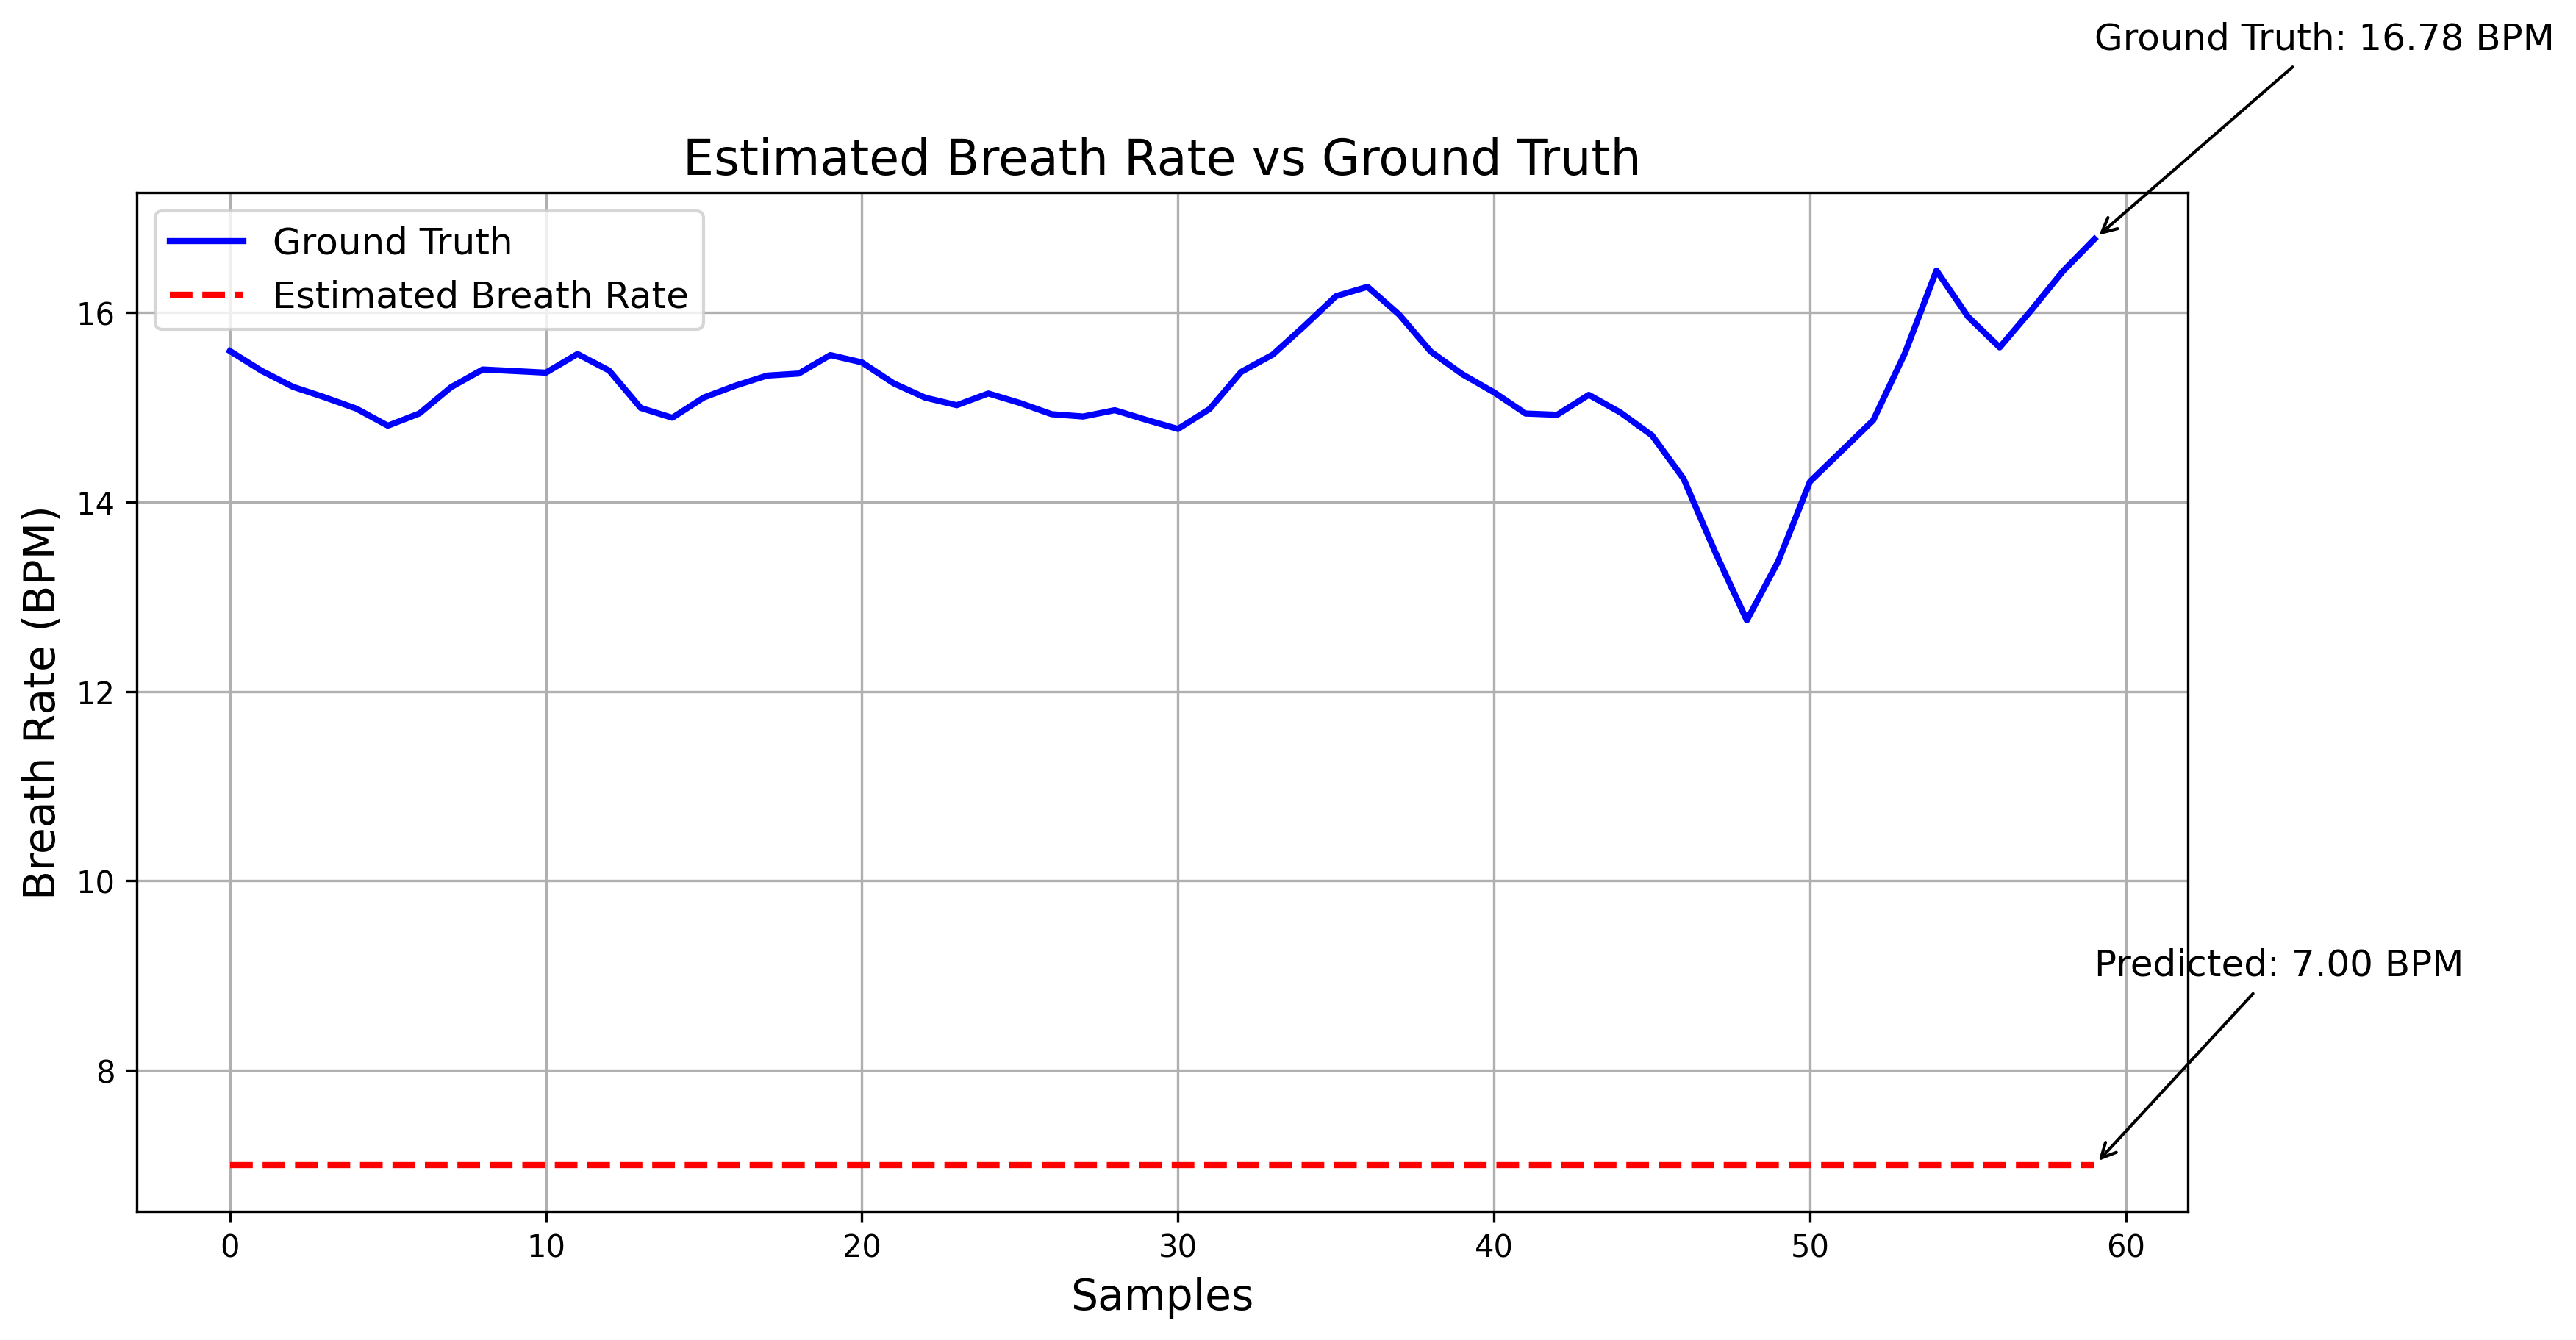

Visualization saved at: Visualization/breath_rate_comparison_with_annotations.png


In [19]:
# Up-sampling function
def upsampling(result, length):
    return [result for _ in range(length)]

# MSE Calculation and Visualization
def MSE(estimated, groundtruth):
    return np.mean((np.array(estimated) - np.array(groundtruth)) ** 2)

for f in filters:
    estimated_breath_rate = results[f]
    final_result = upsampling(estimated_breath_rate, len(groundtruth))
    mse = MSE(final_result, groundtruth)
    
    print(f"{f} Filter - MSE: {mse:.2f}")
    result_visualization(groundtruth, final_result)


In [20]:
from scipy import signal
import numpy as np
from cmath import pi

# Sanitization for Phase Cleaning
def sanitization(x):
    F = len(x)
    phase = np.angle(x)
    phase = np.unwrap(phase)
    a = (phase[-1] - phase[0]) / (2 * pi * F)
    b = sum(phase) / F

    firstpart = (np.arange(F) + 1) * a
    secondpart = np.ones(F) * b
    phase = phase - firstpart - secondpart

    return x * np.exp(1j * phase)

# Preprocessing function for amplitude and phase
def preprocess_amplitude_phase(CSI, filter_type):
    # Separate amplitude and phase
    CSI_amplitude = np.abs(CSI)
    CSI_phase = np.angle(CSI)

    # Check data length
    if CSI_amplitude.shape[0] < 10:
        raise ValueError("Insufficient length of CSI data for filtering.")

    # Apply filters
    if filter_type == "Butterworth":
        b, a = signal.butter(1, [0.002, 0.005], 'bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
        filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)
    elif filter_type == "Gaussian":
        filtered_amplitude = signal.gaussian(CSI_amplitude.shape[0], std=5)
        filtered_phase = signal.gaussian(CSI_phase.shape[0], std=5)
    elif filter_type == "Chebyshev":
        b, a = signal.cheby1(1, 0.1, [0.002, 0.005], btype='bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
        filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)
    elif filter_type == "Bessel":
        b, a = signal.bessel(1, [0.002, 0.005], btype='bandpass', analog=False)
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
        filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)
    elif filter_type == "Kalman":
        raise NotImplementedError("Kalman filter will be added later.")
    else:
        raise ValueError("Unsupported filter type!")

    return filtered_amplitude, filtered_phase

# Test preprocessing with amplitude and phase
filters = ["Butterworth", "Gaussian", "Chebyshev", "Bessel"]
processed_data = {}

for f in filters:
    try:
        print(f"Processing with {f} filter...")
        processed_amplitude, processed_phase = preprocess_amplitude_phase(CSI, f)
        processed_data[f] = (processed_amplitude, processed_phase)
    except ValueError as e:
        print(f"Error during preprocessing with {f}: {e}")


Processing with Butterworth filter...
Processing with Gaussian filter...
Processing with Chebyshev filter...
Processing with Bessel filter...


Processing with Butterworth filter...
Processing with Savitzky-Golay filter...
Processing with Hampel filter...
Processing with Bandpass filter...
Feature extracted for Butterworth filter.
Feature extracted for Savitzky-Golay filter.
Feature extracted for Hampel filter.
Feature extracted for Bandpass filter.
Butterworth Filter - Estimated Breathing Rate: 0.00 BPM
Savitzky-Golay Filter - Estimated Breathing Rate: 0.00 BPM
Hampel Filter - Estimated Breathing Rate: 0.00 BPM
Bandpass Filter - Estimated Breathing Rate: 0.00 BPM
Butterworth Filter - MSE: 231.24
Savitzky-Golay Filter - MSE: 231.24
Hampel Filter - MSE: 231.24
Bandpass Filter - MSE: 231.24


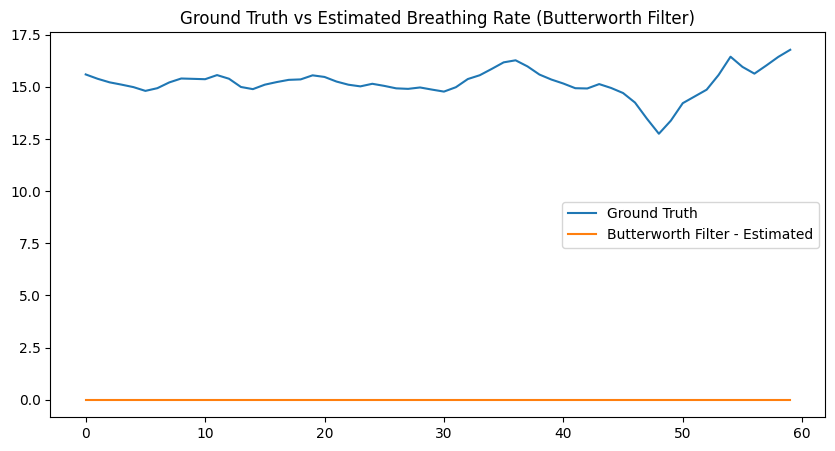

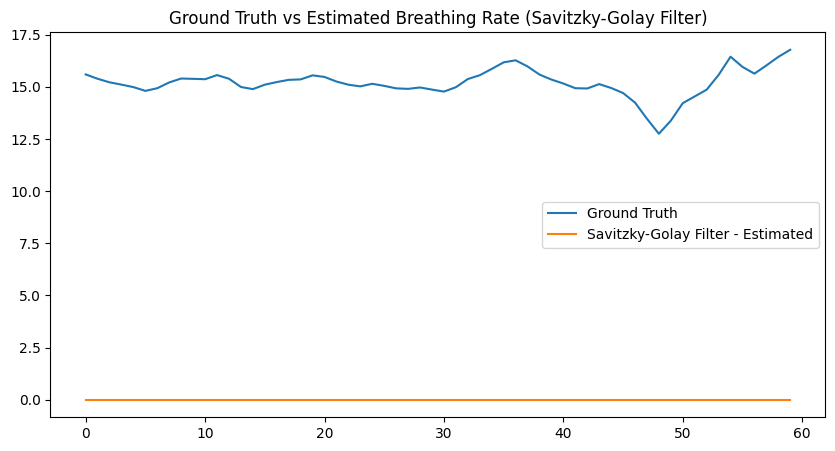

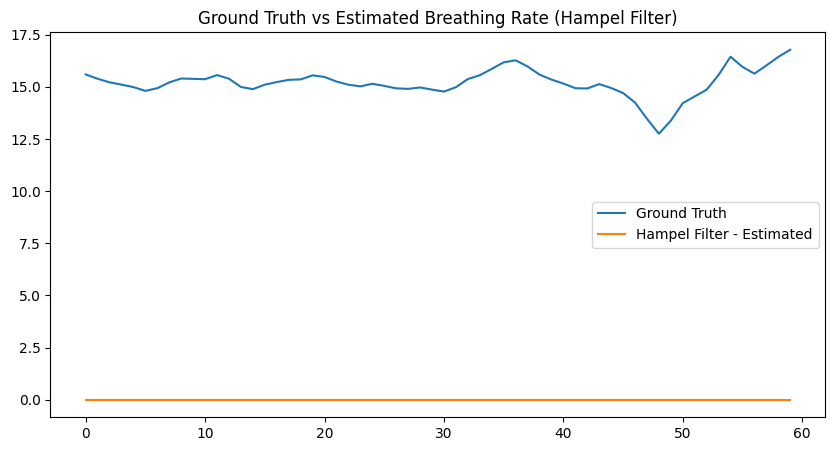

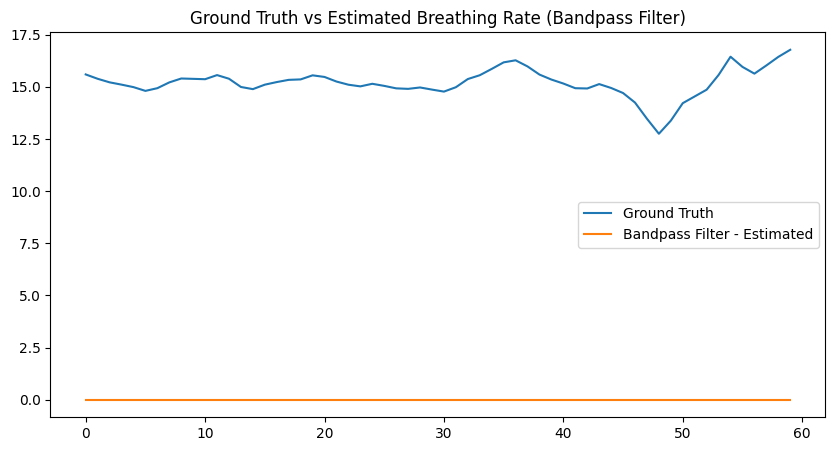

In [21]:
from scipy import signal
from scipy.signal import savgol_filter
import pywt
from statsmodels.robust import mad  # For Hampel Filter

def preprocess_with_filter(CSI, filter_type):
    CSI_amplitude = np.abs(CSI)
    CSI_phase = np.angle(CSI)

    if CSI_amplitude.shape[0] < 10:
        raise ValueError("Insufficient length of CSI data for filtering.")
    
    # Butterworth Filter
    if filter_type == "Butterworth":
        b, a = signal.butter(1, [0.002, 0.005], btype='bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)

    # Savitzky-Golay Filter (Improved with tuned parameters)
    elif filter_type == "Savitzky-Golay":
        filtered_amplitude = savgol_filter(CSI_amplitude, window_length=101, polyorder=3, axis=0)

    # Hampel Filter (Improved with robust parameters)
    elif filter_type == "Hampel":
        window_size = 5  # Tuned window size
        threshold = 3  # Threshold for outlier detection
        filtered_amplitude = np.apply_along_axis(
            lambda x: hampel_filter(x, window_size, threshold), axis=0, arr=CSI_amplitude
        )

    # Bandpass Filter (Validated as baseline)
    elif filter_type == "Bandpass":
        b, a = signal.butter(1, [0.002, 0.005], btype='bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
    
    else:
        raise ValueError(f"Unsupported filter type: {filter_type}")
    
    return filtered_amplitude, CSI_phase

# Hampel Filter Implementation
def hampel_filter(data, window_size, threshold):
    n = len(data)
    filtered = np.copy(data)
    k = 1.4826  # Scaling factor for Gaussian distribution
    for i in range(n):
        window_start = max(0, i - window_size)
        window_end = min(n, i + window_size)
        window_data = data[window_start:window_end]
        median = np.median(window_data)
        mad_value = k * mad(window_data)
        if np.abs(data[i] - median) > threshold * mad_value:
            filtered[i] = median
    return filtered

# Preprocess with filters
filters = ["Butterworth", "Savitzky-Golay", "Hampel", "Bandpass"]
processed_data = {}

for f in filters:
    try:
        print(f"Processing with {f} filter...")
        processed_amplitude, processed_phase = preprocess_with_filter(CSI, f)
        processed_data[f] = (processed_amplitude, processed_phase)
    except Exception as e:
        print(f"Error with {f} filter: {e}")

# Feature Detection with FFT and STFT
features = {}

for f in filters:
    if f not in processed_data:
        continue
    
    processed_amplitude, processed_phase = processed_data[f]
    selected_subcarrier = 15
    selected_Rx, selected_Tx = 0, 1

    # Select amplitude for the chosen subcarrier and antenna pair
    selected_component = processed_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]

    # Use STFT for time-frequency analysis
    frequencies, times, stft_feature = signal.stft(selected_component, fs=100)
    feature = np.abs(stft_feature).mean(axis=1)  # Average over time

    # Save feature
    features[f] = feature
    print(f"Feature extracted for {f} filter.")

# Advanced Peak Detection
results = {}

def advanced_peak_detection(feature, sampling_frequency=100):
    # Autocorrelation for enhanced peak detection
    autocorr = np.correlate(feature, feature, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]  # Use positive lags only
    max_value = np.max(autocorr)
    arg_max = np.argmax(autocorr)
    
    # Convert to frequency and BPM
    frequency = arg_max * (sampling_frequency / len(feature))
    estimated_breath_rate = frequency * 60  # BPM
    return estimated_breath_rate

for f in filters:
    if f not in features:
        continue
    
    feature = features[f]
    estimated_breath_rate = advanced_peak_detection(feature)
    results[f] = estimated_breath_rate
    print(f"{f} Filter - Estimated Breathing Rate: {estimated_breath_rate:.2f} BPM")


# Up-sampling function
def upsampling(result, length):
    return [result for _ in range(length)]

# Calculate MSE for each filter
mse_results = {}

for f in filters:
    if f not in results:
        continue
    
    estimated_breath_rate = results[f]
    final_result = upsampling(estimated_breath_rate, len(groundtruth))
    mse = np.mean((np.array(final_result) - np.array(groundtruth)) ** 2)
    mse_results[f] = mse
    
    print(f"{f} Filter - MSE: {mse:.2f}")

# Visualization
for f in filters:
    if f not in results:
        continue
    
    estimated_breath_rate = results[f]
    final_result = upsampling(estimated_breath_rate, len(groundtruth))
    plt.figure(figsize=(10, 5))
    plt.plot(groundtruth, label="Ground Truth")
    plt.plot(final_result, label=f"{f} Filter - Estimated")
    plt.legend()
    plt.title(f"Ground Truth vs Estimated Breathing Rate ({f} Filter)")
    plt.show()
